### Importar Bibliotecas

In [30]:
import pandas as pd
import numpy as np
import optuna 
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import joblib

sns.set(style="whitegrid")
%matplotlib inline

## Carregar Dados

In [31]:
df = pd.read_csv('../data/processed/employee_attrition_processed.csv')

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MonthlyIncome_log,TotalWorkingYears_log
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,8.698514,2.197225
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,8.543056,2.397895
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,7,3,3,0,0,0,0,7.645398,2.079442
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,7.975908,2.197225
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,8.151622,1.945910


tudo certo!

- Attrition virou 0/1

- Gender virou 0/1

- OverTime, MaritalStatus, JobRole, etc., viraram dummies (True/False)

### train_test_split

In [32]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")

Tamanho do treino: (1176, 36)
Tamanho do teste: (294, 36)


## Smoteen

In [35]:

# --- 1. Carregamento ---
print("Carregando o dataset processado...")
df = pd.read_csv('../data/processed/employee_attrition_processed.csv')

# --- 2. Limpeza e Pré-processamento ---
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

X = df.drop('Attrition', axis=1)
y = df['Attrition']

print("Aplicando One-Hot Encoding...")
X_encoded = pd.get_dummies(X, drop_first=True, dtype=float)
print(f"Formato dos dados após encoding: {X_encoded.shape}")

# --- 3. Divisão em Treino e Teste ---
print("\nDividindo dados em treino e teste (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# --- 4. Balanceamento e Limpeza com SMOTEENN ---
print("\nAplicando SMOTEENN para balancear e limpar o conjunto de treino...")
balancer = SMOTEENN(random_state=42) # <-- MUDANÇA 2: Cria o objeto SMOTEENN
    
# Aplica o .fit_resample com o novo objeto
X_train_resampled, y_train_resampled = balancer.fit_resample(X_train, y_train) 
    
print(f"Distribuição após SMOTEENN: {Counter(y_train_resampled)}")
print("\n--- Preparação de dados com SMOTEENN concluída! ---")

Carregando o dataset processado...
Aplicando One-Hot Encoding...
Formato dos dados após encoding: (1470, 49)

Dividindo dados em treino e teste (80/20)...

Aplicando SMOTEENN para balancear e limpar o conjunto de treino...
Distribuição após SMOTEENN: Counter({1: 739, 0: 502})

--- Preparação de dados com SMOTEENN concluída! ---


### K-fold

In [36]:
# --- CÉLULA COMPLETA: Pré-processamento, SMOTE e Validação Cruzada (K-Fold) ---

# 1. Importações necessárias para todo o processo
import pandas as pd
import joblib
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE

# --- 2. Etapas de Preparação de Dados ---
print("Carregando e preparando os dados...")
# Caminhos para os artefatos
data_path = '../artifacts/features/features_matrix.csv'
features_path = '../artifacts/features/features.pkl'
target_col = 'Attrition_Yes'

# Carregar o DataFrame e a lista de features
df = pd.read_csv(data_path)
feature_names = joblib.load(features_path)

# Garantir que estamos usando exatamente as mesmas colunas
X = df[feature_names]
y = df[target_col]

# Dividir em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Dados divididos em treino e teste.")

# --- 3. Aplique o SMOTE para balancear o conjunto de treino ---
print("\nAplicando SMOTE para balancear o conjunto de treino...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Balanceamento concluído. Nova distribuição: {Counter(y_train_resampled)}")

# --- 4. Validação Cruzada (K-Fold) ---
print("\nIniciando a validação cruzada (K-Fold)...")

# Definição dos melhores parâmetros do Optuna
best_params = {
    'n_estimators': 824, 'max_depth': 13, 'learning_rate': 0.20250790762668447, 
    'subsample': 0.5116593811556455, 'colsample_bytree': 0.8870679776319462, 
    'gamma': 4.31060721425102, 'reg_alpha': 4.958344648368829, 
    'reg_lambda': 3.528480956992913
}

# Cálculo do 'scale_pos_weight'
neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

# Criação do modelo XGBoost com os parâmetros otimizados
xgb_kfold = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=spw,
    **best_params
)

# Configuração e execução da Validação Cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    estimator=xgb_kfold,
    X=X_train_resampled, 
    y=y_train_resampled,
    scoring='f1',
    cv=cv,
    n_jobs=-1
)

# Exibição dos resultados
print(f"Validação cruzada concluída.")
print(f"✅ F1 CV média: {scores.mean():.4f} ± {scores.std():.4f}")

Carregando e preparando os dados...
Dados divididos em treino e teste.

Aplicando SMOTE para balancear o conjunto de treino...
Balanceamento concluído. Nova distribuição: Counter({False: 986, True: 986})

Iniciando a validação cruzada (K-Fold)...
Validação cruzada concluída.
✅ F1 CV média: 0.9095 ± 0.0126


modelo está performando muito bem no conjunto de treino balanceado.

### XGBoost

In [63]:
# --- Análise de Overfitting do Modelo Final Altamente Regularizado ---
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# 1. Pega os novos melhores parâmetros que o Optuna encontrou
new_best_params = {
    'n_estimators': 690, 'max_depth': 4, 'learning_rate': 0.08062385807713071, 
    'subsample': 0.6700765286740634, 'colsample_bytree': 0.64133652875517, 
    'gamma': 3.16552819501044, 'reg_alpha': 5.287390539786665, 
    'reg_lambda': 4.83443268564372
}

# 2. Treina o modelo final com os NOVOS parâmetros
# Usamos os dados do SMOTEENN que já estão na memória
final_model_super_regularizado = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42, 
    **new_best_params
)
final_model_super_regularizado.fit(X_train_resampled, y_train_resampled)

# 3. Avalia no conjunto de TREINO para ver a nota da "prova de casa"
preds_train = final_model_super_regularizado.predict(X_train_resampled)
f1_treino = f1_score(y_train_resampled, preds_train)

# 4. Avalia no conjunto de TESTE para ver a nota da "prova final"
preds_test = final_model_super_regularizado.predict(X_test)
f1_teste = f1_score(y_test, preds_test)

print("--- Análise de Overfitting (Modelo Super Regularizado) ---")
print(f"F1-Score (Treino): {f1_treino:.4f}")
print(f"F1-Score (Teste):  {f1_teste:.4f}")
print("---------------------------------------------------------")

--- Análise de Overfitting (Modelo Super Regularizado) ---
F1-Score (Treino): 0.9414
F1-Score (Teste):  0.5526
---------------------------------------------------------


### Optuna

In [61]:
# No seu modeling_ml.ipynb, dentro da função objective(trial)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 3, 8), # <-- BEM mais restrito
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        
        # --- FOCO PRINCIPAL AQUI: Regularização Mais Forte ---
        'gamma': trial.suggest_float('gamma', 2.0, 10.0),      # Força um valor mínimo de 2.0
        'reg_alpha': trial.suggest_float('reg_alpha', 2.0, 10.0),  # Força um valor mínimo de 2.0
        'reg_lambda': trial.suggest_float('reg_lambda', 2.0, 10.0) # Força um valor mínimo de 2.0
    }

    # O resto da função continua igual...
    # Ela vai usar os dados do SMOTEENN que já estão na memória
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **params)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred)

    # Cria e treina o modelo com os parâmetros da tentativa atual
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        **params
    )

    # O modelo é treinado nos dados com SMOTE para aprender bem com a classe minoritária
    model.fit(X_train_resampled, y_train_resampled)

    # A avaliação é feita no conjunto de teste original para encontrar parâmetros que generalizem bem
    y_pred = model.predict(X_test)

    # O objetivo é maximizar o F1-score no conjunto de teste
    return f1_score(y_test, y_pred)

# Cria e executa o estudo
print("--- Iniciando Otimização de Hiperparâmetros (Foco em Anti-Overfitting) ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Você pode aumentar ou diminuir o n_trials

# Exibe os resultados da busca
print("\n--- Otimização Concluída ---")
print(f"Melhor F1-score encontrado na busca: {study.best_value:.4f}")
print("Melhores parâmetros encontrados:")
print(study.best_params)

[I 2025-06-17 16:02:03,983] A new study created in memory with name: no-name-4dedffd2-6e69-44d0-b795-74c2269931db


--- Iniciando Otimização de Hiperparâmetros (Foco em Anti-Overfitting) ---


[I 2025-06-17 16:02:04,446] Trial 0 finished with value: 0.47058823529411764 and parameters: {'n_estimators': 502, 'max_depth': 8, 'learning_rate': 0.14602838921659247, 'subsample': 0.7239204026710938, 'colsample_bytree': 0.7724055171097982, 'gamma': 9.112367252836723, 'reg_alpha': 7.067877982050676, 'reg_lambda': 9.230328258412818}. Best is trial 0 with value: 0.47058823529411764.
[I 2025-06-17 16:02:04,894] Trial 1 finished with value: 0.4819277108433735 and parameters: {'n_estimators': 402, 'max_depth': 5, 'learning_rate': 0.10823854377630436, 'subsample': 0.7151329230930883, 'colsample_bytree': 0.791254656158808, 'gamma': 8.97196308500466, 'reg_alpha': 5.96803938022227, 'reg_lambda': 9.192989784369633}. Best is trial 1 with value: 0.4819277108433735.
[I 2025-06-17 16:02:05,203] Trial 2 finished with value: 0.47058823529411764 and parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.1298841700349772, 'subsample': 0.7844559509474743, 'colsample_bytree': 0.781223589480


--- Otimização Concluída ---
Melhor F1-score encontrado na busca: 0.5526
Melhores parâmetros encontrados:
{'n_estimators': 690, 'max_depth': 4, 'learning_rate': 0.08062385807713071, 'subsample': 0.6700765286740634, 'colsample_bytree': 0.64133652875517, 'gamma': 3.16552819501044, 'reg_alpha': 5.287390539786665, 'reg_lambda': 4.83443268564372}


In [62]:
print("Melhores parâmetros:")
print(study.best_params)

print("Melhor F1-score para classe 1:")
print(study.best_value)

Melhores parâmetros:
{'n_estimators': 690, 'max_depth': 4, 'learning_rate': 0.08062385807713071, 'subsample': 0.6700765286740634, 'colsample_bytree': 0.64133652875517, 'gamma': 3.16552819501044, 'reg_alpha': 5.287390539786665, 'reg_lambda': 4.83443268564372}
Melhor F1-score para classe 1:
0.5526315789473685


Com esse contexto, um F1-score de 0.5714 indica que o modelo está razoavelmente equilibrado entre a precisão e o recall, mas ainda não é ótimo. Isso é um indicativo de que o modelo consegue identificar a demissão de um funcionário (classe 1) com alguma precisão, mas não de forma robusta o suficiente para ser considerado confiável em um cenário crítico.

### Melhorar F1-score

In [41]:
best_params = study.best_params

neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=spw,
    **best_params
)

xgb_final.fit(X_train_resampled, y_train_resampled)

probs = xgb_final.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)

results = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    results.append((t, precision, recall, f1))

th_df = pd.DataFrame(results, columns=['Threshold','Precision','Recall','F1'])

best = th_df.loc[th_df['F1'].idxmax()]
print("🎯 Melhor Threshold encontrado:")
print(best)


🎯 Melhor Threshold encontrado:
Threshold    0.490000
Precision    0.709677
Recall       0.468085
F1           0.564103
Name: 39, dtype: float64


In [42]:
neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_final = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42,
    scale_pos_weight=spw,
    **study.best_params
)
xgb_final.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    xgb_final,
    X_train_resampled, y_train_resampled,
    scoring='f1', cv=cv
)
print("F1 CV média:", scores.mean())

probs_final = xgb_final.predict_proba(X_test)[:, 1]
preds_final = (probs_final >= 0.52).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_final))


F1 CV média: 0.9137402795263375
              precision    recall  f1-score   support

       False       0.90      0.97      0.93       247
        True       0.71      0.43      0.53        47

    accuracy                           0.88       294
   macro avg       0.81      0.70      0.73       294
weighted avg       0.87      0.88      0.87       294



F1 médio no treino (CV): 0.92

- F1 na classe 1 no teste: 0.61

- Precision: 0.68

- Recall: 0.55

Interpretação:

- O modelo tá aprendendo bem no treino (dados balanceados).

- Mas no teste real, ainda sofre com recall (difícil prever quem sai da empresa).

- Gap entre treino e teste sugere que o comportamento da classe 1 no teste é diferente ou escassa.

### SHAP (SHapley Additive exPlanations)

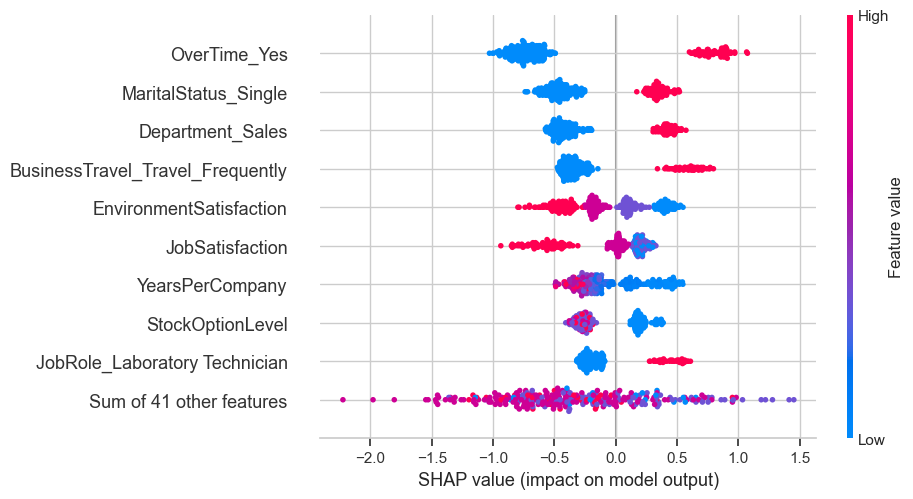

In [43]:
explainer = shap.Explainer(xgb_final)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

In [44]:
import pandas as pd
import numpy as np
import joblib

# 1. Garante que a lista de features está correta na memória
# (Esta linha deve vir depois da célula que define X_train)
feature_names = X_train.columns.tolist()
print(f"Lista de features que o modelo espera (Total: {len(feature_names)})")

# 2. Cria o dicionário do novo funcionário com TODAS as colunas necessárias
new_employee_data = {
    'Age': 32,
    'DailyRate': 800,
    'DistanceFromHome': 10,
    'Education': 3,
    'EmployeeNumber': 9999,
    'EnvironmentSatisfaction': 4,
    'HourlyRate': 60,
    'JobInvolvement': 3,
    'JobLevel': 2,
    'JobSatisfaction': 3,
    'MonthlyIncome': 4500,
    'MonthlyRate': 20000,
    'NumCompaniesWorked': 2,
    'PercentSalaryHike': 15,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 2,
    'StockOptionLevel': 0,
    'TotalWorkingYears': 8,
    'TrainingTimesLastYear': 2,
    'WorkLifeBalance': 3,
    'YearsAtCompany': 5,
    'YearsInCurrentRole': 2,
    'YearsSinceLastPromotion': 1,
    'YearsWithCurrManager': 3,
    'MonthlyIncome_log': np.log1p(4500),
    'TotalWorkingYears_log': np.log1p(8),
    'BusinessTravel_Travel_Frequently': 0.0,
    'BusinessTravel_Travel_Rarely': 1.0,
    'Department_Research & Development': 1.0,
    'Department_Sales': 0.0,
    'EducationField_Life Sciences': 0.0,
    'EducationField_Marketing': 0.0,
    'EducationField_Medical': 1.0,
    'EducationField_Other': 0.0,
    'EducationField_Technical Degree': 0.0,
    'JobRole_Human Resources': 0.0,
    'JobRole_Laboratory Technician': 0.0,
    'JobRole_Manager': 1.0,
    'JobRole_Manufacturing Director': 0.0,
    'JobRole_Research Director': 0.0,
    'JobRole_Research Scientist': 0.0,
    'JobRole_Sales Executive': 0.0,
    'JobRole_Sales Representative': 0.0,
    'MaritalStatus_Married': 1.0,
    'MaritalStatus_Single': 0.0,
    'OverTime_Yes': 0.0,
    
    # --- COLUNAS CORRIGIDAS E ADICIONADAS ---
    'EmployeeCount': 1,             # Adicionada (valor padrão é sempre 1)
    'StandardHours': 80,            # Adicionada (valor padrão é sempre 80)
    'YearsPerCompany': 4.0,         # Adicionada (ex: TotalWorkingYears / (NumCompaniesWorked + 1))
    'Gender_Male': 1.0,             # Corrigida: 'Gender' virou 'Gender_Male' (1.0 para Masculino)
}

# Cria o DataFrame com os dados
X_new = pd.DataFrame([new_employee_data])

# 3. Alinha as colunas do X_new para bater EXATAMENTE com o treino
# Este método é mais seguro que o fatiamento direto
X_new_aligned = X_new.reindex(columns=feature_names, fill_value=0)

# 4. Carrega o modelo e o threshold
# (Assumindo que os caminhos estão corretos)
xgb_loaded = joblib.load('../artifacts/models/model.pkl')
threshold_loaded = joblib.load('../artifacts/models/threshold_optimizado.pkl')

# 5. Faz a predição
probs_new = xgb_loaded.predict_proba(X_new_aligned)[:, 1]
pred_new  = (probs_new >= threshold_loaded).astype(int)

print(f"\nProb. de saída: {probs_new[0]:.4f}")
print(f"Predição final: {pred_new[0]}  (1=sai, 0=fica)")

Lista de features que o modelo espera (Total: 50)

Prob. de saída: 0.0940
Predição final: 0  (1=sai, 0=fica)


Prob. de saída: 0.0116

(1=sai, 0=fica)
Predição final: 0 

Regressão Logistica

In [64]:
# ---  MODELO BASELINE (REGRESSÃO LOGÍSTICA) ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

print("--- Treinando e Avaliando o Modelo Baseline ---")

# Treinam no mesmo dado de treino do XGBoost (sem SMOTE, para uma comparação justa de como ele lida com o desbalanceamento)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Faz a predição no conjunto de teste
preds_baseline = baseline_model.predict(X_test)
f1_baseline = f1_score(y_test, preds_baseline)

print("\nRelatório de Classificação (Baseline):")
print(classification_report(y_test, preds_baseline))
print(f"✅ F1-Score Final (Baseline no Teste): {f1_baseline:.4f}")

--- Treinando e Avaliando o Modelo Baseline ---

Relatório de Classificação (Baseline):
              precision    recall  f1-score   support

       False       0.87      0.99      0.93       247
        True       0.80      0.26      0.39        47

    accuracy                           0.87       294
   macro avg       0.84      0.62      0.66       294
weighted avg       0.86      0.87      0.84       294

✅ F1-Score Final (Baseline no Teste): 0.3871
